<a href="https://colab.research.google.com/github/EGaraldi/EPIC_5/blob/main/Tutorials/tutorial_2/CFD_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tutorial 2: Catching a river in your laptop - methods for numerically solving differential equations
==================================

## About me
* Italian, 35 years old.
* As a kid I wanted to be a motorcycles pilot. Then an astronomer. Then a theoretical physicist. I studied Theoretical physics, but a horrible professor made me hate the subject, so I went back to astrophysics.
* I'm a numerical astrophysicist = I run simulations of the formation of galaxies and structures in the Universe. Then, I use these virtual universes to try to understand the history of the cosmos.

# What is CFD?
Computational fluid dynamics (CFD) is a big branch of physics and engineering that uses computer simulations to understand the complex behaviors of fluids, especially in systems that are impossible to study with traditional methods. This can cover a **huge** range of systems, from F1 cars and airplanes to a fridge; from a river to galaxies; and sometimes even light.

## What is a fluid?
In physics, we have a precise definition of what a fluid is. But for today, the only thing that matters is that a fluid:
* is described by a set of values at each point (for example, the water temperature, density and velocity in a river); mathematically, we call this a field.
* changing the fluid properties in one point affects the nearby one (for example, if you jump into the water you will create a splash).

These conditions are true for many more _stuff_ than fluids only, so whet you will learn today can be used for many more physical systems.

Now maybe you see why CFD has such broad applications! For example, if you want to design a fridge, you need to make sure that the liquid coolant reaches each corner of the fridge as efficiently as possible. And if you want to understand how stars function, you need to understand how the hot gas flows through their interiors. Both can be soled with the same CFD methods!

CFD is used in many fields, including:
- Engineering
- Weather forecasting
- Oceanography
- Astrophysics


# Discretization
Most physical systems are described by **partial differential equations (PDEs)**, which are continuous in space and time. Therefore, to describe such system in a computer, we need an **infinite** amount of numbers, one (set of) numbers for each position in the fluid. No matter how large your computer is, it is impossible to fit an infinite amount of infinite numbers in it!

We deal with this through **discretization** of the system (for example our fluid) in _both space and time_. By this, I mean that we split a continuous field into a number of small elements, that we assume are described by a single set of values. For a one-dimensional system, the spatial discretization looks like this:

![discretization](https://media.geeksforgeeks.org/wp-content/uploads/20190508222632/0f67a451-4895-4a17-9e5f-3bd80f7d2545-300x200.png)

Each one of these _resolution elements_ represents the smallest length $\Delta x$ (or area, or volume) that has a meaning in the discretized system. Therefore, we can describe a (1D) system with a set of points

$$x_0, \,\, x_1, \,\, x_2, \,\, x_3, \,\, x_4, ...$$

separated by $\Delta x$, so that $x_n = x_0 + n\Delta x$.


> You can think of this as the resolution of an image/screen/etc. The more pixels (resolution elements) you have, the closer it is to the real thing, but it will never have all the details
>
> <img src="https://github.com/EGaraldi/EPIC_5/blob/main/Tutorials/tutorial_2/pxArt0.png?raw=1" width="50%"/>
>
> <img src="https://github.com/EGaraldi/EPIC_5/blob/main/Tutorials/tutorial_2/pxArt1.png?raw=1" width="50%"/>
>
> <img src="https://github.com/EGaraldi/EPIC_5/blob/main/Tutorials/tutorial_2/pxArt2.png?raw=1" width="50%"/>
>
> <img src="https://github.com/EGaraldi/EPIC_5/blob/main/Tutorials/tutorial_2/pxArt3.png?raw=1" width="50%"/>

We treat time in the same way. This means that we treat a continuous evolution in time as a sequence of discrete times

$$t_0, \,\, t_1, \,\, t_2, \,\, t_3, \,\, t_4, ...$$

separated by an interval $\Delta t$ so that $t_n = t_0 + n\Delta t$. This interval $\Delta t$ is called _timestep_.

To make the notation easier, if a system is described by a state function $u(x, t)$ (for example, the water temperature, ...), we will write the state at timestep $t_n = t_0 + n \Delta t$ at position $x_i = x_0 + i \Delta x$ as

$$u(x_i, t_n)  = u(x_0 + i \Delta x, t_0 + n \Delta t) \equiv u_i^n$$


## Finite differences
In a discretized system, we need to find a suitable definition for continuous operators. The only one we will need today is the derivative $\partial f/\partial x$.

Mathematically, the derivative is defined (in 1 dimension) as:

$$
\frac{\partial f}{\partial x} = \lim_{\epsilon \rightarrow 0} \frac{f(x+\epsilon) - f(x)}{\epsilon}
$$

In a discretized system, however, we can not take the limit $\epsilon \rightarrow 0$, because the smallest meaningful length is the resolution element $\Delta x$. So, we replace this limit with a _finite difference_. For example:

$$
\frac{\partial f}{\partial x} \approx \frac{f(x+\Delta x) - f(x)}{\Delta x} = \frac{f_{i+1} - f_i}{\Delta x}
$$

This is called _forward derivative_, because the difference is computed between the current value ($f_i$) and the next one ($f_{i+1}$).

In the same way, we can define a _backward derivative_, as:

$$
\frac{\partial f}{\partial x} \approx \frac{f(x) - f(x-\Delta x)}{\Delta x} = \frac{f_i - f_{i-1}}{\Delta x}
$$

Both of these are correct, but the fact that they are not symmetric in x creates some numerical issues sometimes (more on this later). Therefore, it is usually better to use the _central derivative_:

$$
\frac{\partial f}{\partial x} \approx \frac{f(x+\Delta x) - f(x-\Delta x)}{2 \Delta x} = \frac{f_{i+1} - f_{i-1}}{2\Delta x}
$$


When we encounter a time derivative, we can proceed like we did before for the spatial dimension $x$. However, in this case we do **not know** the future state $u(x, t_{n+1})$, because that is what we want to predict with our simulation!


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def forward_derivative(f, dx):
    deriv = np.full_like(f, None)
    for i in range(len(f)-1):
        deriv[i] = ( f[i+1] - f[i] ) / dx
    # the following way is more efficient because uses the numpy internal vectorization (but less transparent)
    # deriv[:-1] = (f[1:] - f[:-1]) / dx
    return deriv

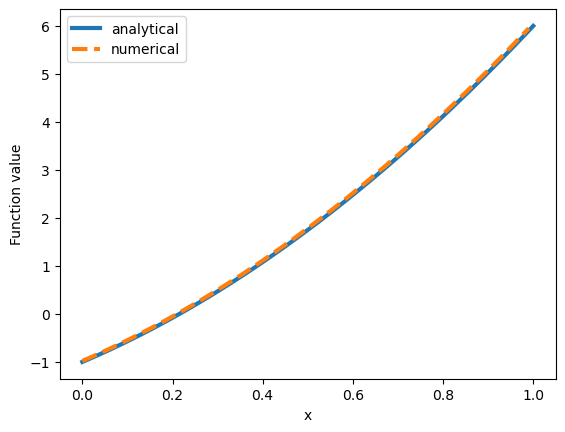

In [3]:
L = 1.0  # Length of the domain
N = 100  # Number of spatial points
dx = L / (N - 1)  # Spatial step size
x = np.linspace(0, L, N)
f = x**3 +2*x**2 - x
df_analytical = 3*x**2 + 4*x - 1
df_numerical = forward_derivative(f, dx)

plt.plot(x, df_analytical, label="analytical", linestyle='-' , lw=3)
plt.plot(x, df_numerical, label="numerical"  , linestyle='--', lw=3)

plt.xlabel('x')
plt.ylabel('Function value')

plt.legend()


In [4]:
def backward_derivative(f, dx):
    deriv = np.full_like(f, None)
    deriv[1:] = (f[1:] - f[:-1]) / dx
    return deriv

In [5]:
def central_derivative(f, dx):
    deriv = np.full_like(f, None)
    deriv[1:-1] = (f[2:] - f[:-2]) / (2*dx)
    return deriv

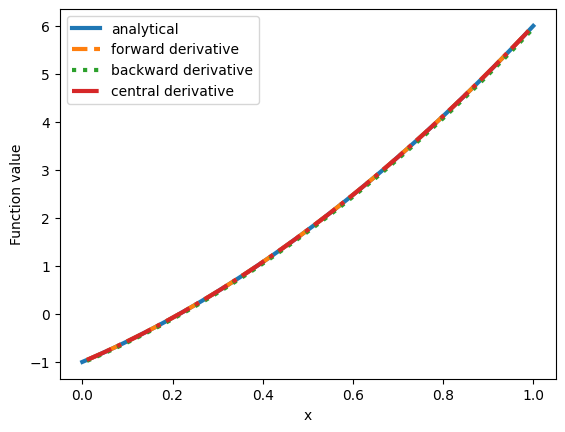

In [10]:
L = 1.0  # Length of the domain
N = 100  # Number of spatial points
dx = L / (N - 1)  # Spatial step size
x = np.linspace(0, L, N)
f = x**3 +2*x**2 - x
df_analytical = 3*x**2 + 4*x - 1

plt.plot(x, df_analytical, label="analytical", linestyle='-' , lw=3)
plt.plot(x, central_derivative(f, dx), label="forward derivative", linestyle='--', lw=3)
plt.plot(x, backward_derivative(f, dx), label="backward derivative", linestyle=':', lw=3)
plt.plot(x, central_derivative(f, dx), label="central derivative", linestyle='-.', lw=3)

plt.xlabel('x')
plt.ylabel('Function value')

plt.legend()


### Second derivative

Often in physics we find second derivatives. We can simply treat them as the derivative of a derivative and apply twice the forward/backward/central derivative. For example:

``` second_derivative = central_derivative(central_derivative(f, dx), dx) ```

However, we can combine a forward and a backward derivative, we end up with:

$$
\frac{\partial^2 f}{\partial x^2} \approx \frac{f(x+\Delta x)+(x-\Delta x)-2(x)}{(\Delta x)^2}
$$

This expression treats at the same way the forward and backward grid point (i.e. it is symmetric with respect to $x$). Since it does not artificially break the symmetry of the system, it reduces the overall discretization error. So we can define:

In [11]:
def second_derivative(f, dx):
    deriv = np.full_like(f, None)
    deriv[1:-1] = (f[2:] + f[:-2] - 2*f[1:-1]) / (dx**2)
    return deriv

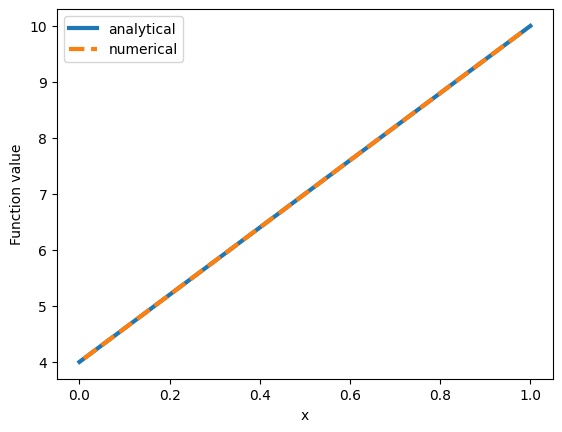

In [13]:
L = 1.0  # Length of the domain
N = 100  # Number of spatial points
dx = L / (N - 1)  # Spatial step size
x = np.linspace(0, L, N)
# f = np.concatenate([np.zeros(N//2), np.ones(N//2)])  # Step function
# f = np.exp(-100 * (x - 0.5)**2)  # Gaussian
f = x**3 +2*x**2 - x
df2_analytical = 6*x + 4

plt.plot(x, df2_analytical, label='analytical', lw=3)
plt.plot(x, second_derivative(f, dx), label="numerical", linestyle='--', lw=3)

plt.xlabel('x')
plt.ylabel('Function value')

plt.legend()


# The basic simulation step

With this, we can finally build a _simulation step_. Suppose that a physical systems can be described by equations in the form

$$\frac{\partial u(x, t)}{\partial t} = f(x,t)$$

where $f(x,t)$ can contain _spatial_ derivatives but no time derivative.

Using the finite differences above, this becomes:

$$\frac{u(x, t_{n+1}) - u(x, t_{n})}{\Delta t} = f(x,t_n)$$

$$\rightarrow u(x, t_{n+1}) = u(x, t_{n}) + f(x,t_n) \Delta t $$

This is a recipe to use the current state of the system $u(x, t_{n})$ to predict the **future** state of the system $u(x, t_{n+1})$. By repeating this procedure until we reach our desired final time, we can simulate the system. This is the basic concept behind numerical simulations.

## Initial and boundary conditions

The recipe above tells us how to _evolve_ a system, but we need a starting configuration. This is called **initial condition** of the simulation and depends on what you are trying to simulate.

We can also have **boundary conditions**. These are a set of rules that determine what happens at the edge of our simulation and depend on what we are simulating. For example, if we are simulating a wave in the ocean, we probably want the wave to travel past the edge of the simulation because in the ocean there is nothing stopping a wave from traveling. But if we are simulating the same wave in a pool, maybe we want the wave to reflect on the pool edge.

# Case 1: the advection equation

The advection equation simply describes the rigid transport of a wave. In 1 dimension, this is:

$$ \frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} = 0 $$

where $c$ is the propagation speed and the state $u$ describes the wave.

Discretizing space and time, and using finite differences to approximate derivative, we get

$$ \frac{u(x_i, t_{n+1}) - u(x_i, t_{n})}{\Delta t} + c \frac{u(x_{i+1}, t_n) - u(x_{i-1}, t_n)}{2 \Delta x} = 0 $$

$$\rightarrow u(x_i, t_{n+1}) = u(x_i, t_{n}) - (c \Delta t) \frac{u(x_{i+1}, t_n) - u(x_{i-1}, t_n)}{2 \Delta x}

  0%|          | 0/7000 [00:00<?, ?it/s]

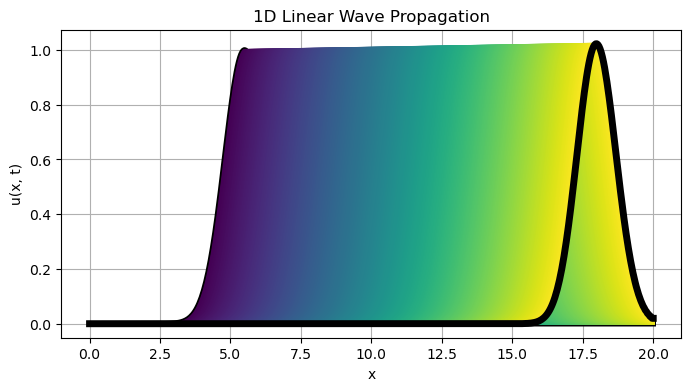

In [11]:
from tqdm.notebook import trange

# Define the system
L = 20.0            # spatial length
T = 50             # total simulation length
c = 0.25            # wave speed

#discretization
nx = 500           # number of spatial points
nt = 7000           # number of time steps

# compute spatial and time steps
dx = L / (nx - 1)  # spatial step
dt = T / (nt - 1)  # time step

# Create spatial grid
x = np.linspace(0, L, nx, endpoint=True)

# Set initial conditions
u = np.exp(-1 * (x - 5.5)**2)  # Gaussian pulse

#evolve the system
def evolve_one_step(u):
    u_new = u - c*dt*central_derivative(u,dx)
    #boundary conditions:
    #  at the edge of the domain
    u_new[0] = u_new[1]
    u_new[-1] = u_new[-2]

    return u_new

# Plot result
plt.figure(figsize=(8, 4))
cmap = plt.get_cmap("viridis")
plt.plot(x, u, color='k', lw=4)

# Time evolution
for n in trange(nt):
    u_new = evolve_one_step(u)

    #now replace old state with new state
    u = u_new

    #plot every now and then
    if n % 10 == 0:
        plt.plot(x, u, color=cmap(n/nt))

plt.plot(x, u, '-k', lw=5)
plt.title("1D Linear Wave Propagation")
plt.xlabel("x")
plt.ylabel("u(x, t)")
#plt.legend()
plt.grid(True)
plt.show()

## Exercise: forward, backward and central derivative
Try to replace the central derivative above with forward and backward derivatives. Then, try to reduce the integration time, dt or dx.

# Case 2: the wave equation

The second example is the propagation of a wave in 1 (spatial) dimension. Mathematically, we can describe the 1D wave propagation as:

$$ \frac{\partial^2 u}{\partial t^2} = c^2 \frac{\partial^2 u}{\partial x^2}$$

where $c$ is the wave speed. You can thin of this as the deformation of a guitar string. In this case, the state of the system $u(x,t)$ is the offset along the $y$ direction, i.e. $u(x,t) = y(x,t)$.

Discretizing space and time, and using finite differences to approximate derivative, we get

$$
\frac{u_{i}^{n+1} + u_{i}^{n-1} - 2 u_{i}^n}{\Delta t^2} = c^2 \frac{u_{i+1}^n + u_{i-1}^n - 2 u_{i}^n}{(\Delta x)^2}
$$

We can isolate the (unknown) future state $u_{i}^{n+1}$ to get

$$
u_{i}^{n+1} = 2 \left[ 1 - \left( \frac{c \Delta t}{\Delta x} \right)^2 \right] u_{i}^{n} + \left( \frac{c \Delta t}{\Delta x} \right)^2 \left( u_{i+1}^{n} + u_{i-1}^{n} \right) - u_{i}^{n-1}
$$

For simplicity, we can define

$$
r \equiv \frac{c \Delta t}{\Delta x}
$$

and get the update rule

$$u_{i}^{n+1} = 2 \left[ 1 - r^2 \right] u_{i}^{n} + r^2 \left( u_{i+1}^{n} + u_{i-1}^{n} \right) - u_{i}^{n-1}$$

## Initial and boundary conditions
Since we are dealing with a second-order differential equation, we require two sets of initial conditions (for each discretization element). For instance, we may know the deformation of the string (elements) at two consecutive timesteps, or we may know the initial position and velocity of the string (elements).

We also need some boundary conditions. Since we can not simulate infinite systems, we have to specify what happens at the boundaries, i.e. the first and last resolution element. In the case of a string, this means deciding what happens at its extremities. One common assumption is that the string is held fix in position, so $u(x=0, t) = u(x=L, t) = 0$ at any time $t$. We can choose, however, any type of boundary condition that makes sense for our system.

An important class of boundary conditions are the periodic boundary condition (PBC). In our example, this corresponds to joining together the two extremes of the string, so we have a string loop. In this case, we have simply $ y_i^n = y_0^n $. This is extremely important in some applications, because it is a simple way to approximate an infinite system in the computer.


## Implementation
We can now implement an algorithm to compute the value of $u_i^{n+1}$ given the values in the two previous timesteps $u_i^n$ and $u_i^{n-1}$. We will assume to have fixed boundary conditions.

In [16]:
# Define the system
L = 20.0            # spatial length
T = 50              # total simulation length
c = 0.2               # wave speed

#discretization
nx = 1000            # number of spatial points
nt = 1000             # number of time steps

# compute spatial and time steps
dx = L / (nx - 1)  # spatial step
dt = T / (nt - 1)  # time step
r = c * dt / dx

print(r)

#create spatial grids
old_step     = np.zeros(nx)
current_step = np.zeros(nx)
new_step     = np.zeros(nx)

0.5000000000000001


In [17]:
def advance_one_step():
    for i in range(1,nx-1):
        new_step[i] = 2*(1-r**2) * current_step[i] \
                      + (r**2) * ( current_step[i+1] + current_step[i-1] ) \
                      - old_step[i]


We now have to choose some initial conditions. To keep things simple (for now!), we will assume that the initial isplacement of the string follows a Gaussian curve centered in some place along the string (in this case at $x_c = 30$).

In [33]:
def make_initial_conditions(center, amplitude, sigma):
    x = np.linspace(0,L,nx)
    initial_step = amplitude * np.exp(-(x-center)**2/sigma**2)
    return initial_step

In [42]:
old_step     = make_initial_conditions(5, 1, 1)
current_step = make_initial_conditions(5, 1, 1)

  0%|          | 0/1000 [00:00<?, ?it/s]

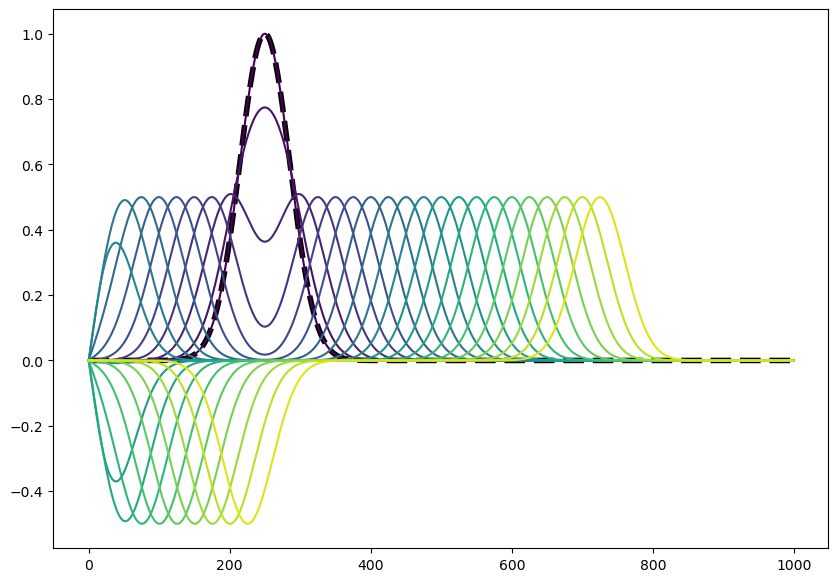

In [43]:
fig, ax = plt.subplots(1,1, figsize=(10,7))

ax.plot(current_step, 'k--', lw=4)

for iteration_number in trange(nt):
    print(f"iteration {iteration_number}", end='\r')
    advance_one_step()

    if iteration_number%50==0:
        ax.plot(current_step, color=plt.cm.viridis(iteration_number/nt))

    #now update step variables
    old_step = current_step.copy()
    current_step = new_step.copy()

plt.show()

We can see that the initial Gaussian curve immediately split into two waves, traveling in opposite direction, with half of the original amplitude. This is due to the assumption `old_step = current_step.copy()`, which means the wave has zero velocity before the start of the simulation. Therefore, the energy stored in the system (for example, due to the tension of a deformated string) is equally split in the two directions to conserve the total momentum (which is zero since the initial velocity is zero). This is not at all absurd. In fact, this is what happens when we pluck a guitar string. You can also see that when one of these waves (the left one) reaches the end of the string it is reflected back, but its ampliude is inverted! This is a well-known phenomenon in wave theory.

### What about the traveling wave?

However, we started this discussion saying that every function $f(x \pm ct)$ satisfy the wave equation and represent a deformation traveling in one direction. To see that, we have to drop the assumption of zero initial velocity (which conflicts with the functional form assumed here), and instead realise that in a time step of the simulation, the wave travels by $\mathrm{d} x = c \Delta t$ (notice how $\mathrm{d} x$ is **not** the same as $\Delta x$). By remembering the definition of the parameter $r$ we can write $\mathrm{d} x = c \Delta t = r \Delta x$. In our example, we have (somewhat implicitly) assumed that $\Delta x = 1$ and chosen $r=1$, therefore $\mathrm{d} x = 1$. This means that in the timestep before the beginning of the simulation, the Gaussian deformation was centered at $x_c - \mathrm{d} x = x_c - 1$. We can then set up these new initial conditions and perform the simulation again.

In [33]:
current_step = make_initial_conditions(5     , 1, 1)
# For a traveling wave, in the step before the wave was at the current position minus c*dt.
old_step     = make_initial_conditions(5-c*dt, 1, 1)

  0%|          | 0/1000 [00:00<?, ?it/s]

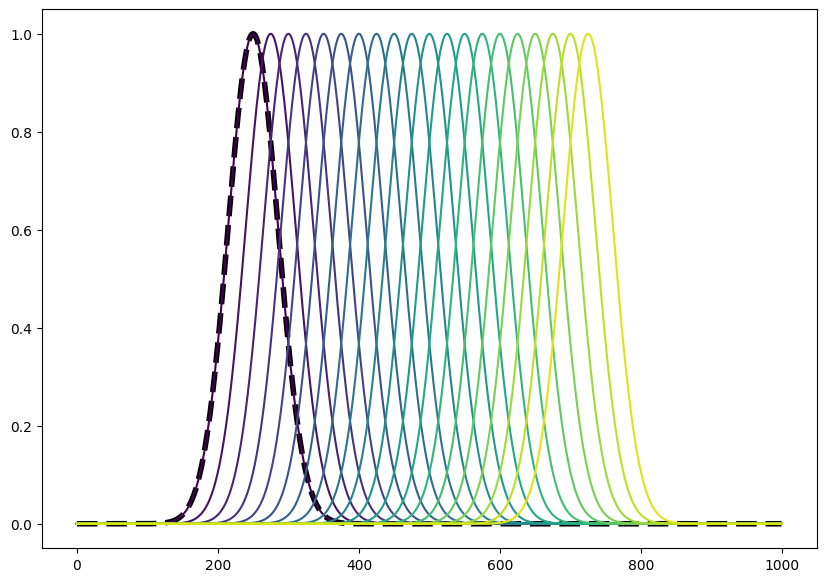

In [34]:
fig, ax = plt.subplots(1,1, figsize=(10,7))

ax.plot(current_step, 'k--', lw=4)

for iteration_number in trange(nt):
    print(f"iteration {iteration_number}", end='\r')
    advance_one_step()

    if iteration_number%50==0:
        ax.plot(current_step, color=plt.cm.viridis(iteration_number/nt))

    #now update step variables
    old_step = current_step.copy()
    current_step = new_step.copy()

plt.show()

## Exercise: PBC
Modify the code above to include periodic boundary conditions

## Exercise: resolution effects
Reduce more and more the width of the Gaussian in the initial conditions (the `sigma` parameter) and see what happens when it gets close to `dx`. 
* hint: you can specify `sigma` as a multiple of `dx` and reduce the multiplication factor progressively

# The Courant-Friedrich-Levy condition
Until now, we have not paid particular attention (or attention at all!) at the values chosen for some quantities of the system, like the spatial and time discretization, the string length, etc. It is time to fix this by discussing the role of the parameter $r$, defined as

$$
r \equiv \frac{c \Delta t}{\Delta x}
$$

The value of $r$ is the ratio between the distance traveled by a signal of speed $c$ in the time $\Delta t$ and the spatial resolution $\Delta x$ of our discretization. What does this mean?

Imagine that $c \Delta t > \Delta x$ (i.e. $r>1$). In this case, within a single time step $\Delta t$, the information carried by the wave (for example the distortion of the string) crosses an entire resolution element. But our algorithm can only communicate information between _adjacent_ resolution elements. In other words, the resolution element that is completely traversed by the wave will never "realize" that something happened! So when we will try to perform another step forward in the simulation, this element will have the wrong value, compromising the results of its neighbors. The step afterward, the pollution will propagate to the neighbors of its neighbors, and so on... Therefore, we must choose a value of $r \leq 1$.

To see how terrible the results can be, try changing the wave speed until you get $r>1$.

1.05


  0%|          | 0/1000 [00:00<?, ?it/s]

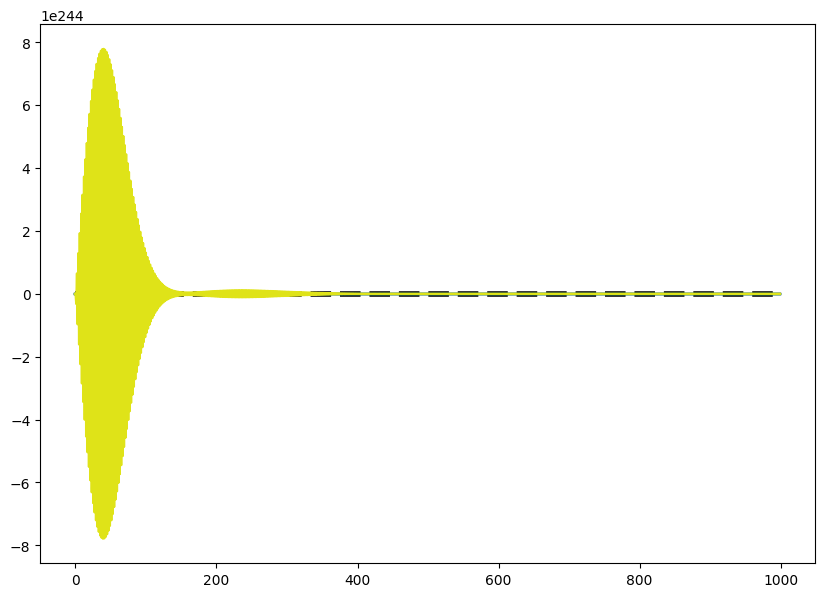

In [35]:
# Define the system
L = 20.0            # spatial length
T = 50              # total simulation length
c = 0.42               # wave speed

#discretization
nx = 1000            # number of spatial points
nt = 1000             # number of time steps

# compute spatial and time steps
dx = L / (nx - 1)  # spatial step
dt = T / (nt - 1)  # time step
r = c * dt / dx

print(r)

#create spatial grids
old_step     = np.zeros(nx)
current_step = np.zeros(nx)
new_step     = np.zeros(nx)



current_step = make_initial_conditions(5     , 1, 1)
# For a traveling wave, in the step before the wave was at the current position minus c*dt.
old_step     = make_initial_conditions(5-c*dt, 1, 1)



fig, ax = plt.subplots(1,1, figsize=(10,7))

ax.plot(current_step, 'k--', lw=4)

for iteration_number in trange(nt):
    print(f"iteration {iteration_number}", end='\r')
    advance_one_step()

    if iteration_number%50==0:
        ax.plot(current_step, color=plt.cm.viridis(iteration_number/nt))

    #now update step variables
    old_step = current_step.copy()
    current_step = new_step.copy()

plt.show()

The lesson to be learned here is very profound. In fact, this reasoning applies to **all** system in which there is transmission of information. For example, if we are simulating how sound propagates in the air, we still have to satisfy the condition $r\leq1$, now using the speed of sound as $c$. This is a fundamental principle used in virtually all simulations of gas dynamics, from the internal working of a fridge to the evolution of the Universe. If you have multiple types of waves traveling in the system simulated (for instance sound waves and gravity waves), $c$ has to be the *largest* among the wave speeds.

In practice, what usually happens is that the spatial resolution $\Delta x$ is set by other constraints (for example, the size of the processes to simulate, or the memory available in the computer). Then, a value of $r$ is chosen and the time step is computed as

$$
\Delta t \leq r \frac{\Delta x}{c}
$$

This is called **Courant–Friedrichs–Lewy (CFL) condition** and it is a necessary criterion for the stability of numerical schemes solving hyperbolic partial differential equations. The constant r is often called the _Courant factor_.

The CFL condition is _necessary but not sufficient_ for the algorithm to be stable. In the wave equation example above, $r = 1$ works, but in many practical situations, we actually need $r \lesssim 0.3$ to have meaningful results.

# Profiling and optimization of the code
Our implementation is relatively straightforward. This help the readability of the code and the clarity of thoughts, but also means the code is not optimized. Here we will briefly look at possible optimization of our simple code, but  before actually implementing any of these, it is important to check *which* part of the code is actually slow. We do not want to spend time optimizing a section that is already fast compared to the rest, because we would not gain much from all the work. The process of measuring the time of each code part and identifying the bottlenecks is called **code profiling**.

![isitworthit](https://imgs.xkcd.com/comics/is_it_worth_the_time.png)

Possible optimizations for our code are:
* avoid copying `current_step` into `old step` and `new_step` into `current_step`. Copying large chunks of memory can be very (time) expensive. Instead we could have three arrays and change their role based on the iteration number, so that we never copy memory. For example we could do the following:
> ```python
>
> array0 = np.zeros((nx, nx))
> array1 = np.zeros((nx, nx))
> array2 = np.zeros((nx, nx))
>
> if iteration_number % 3 == 0:
>     new_step = array0
>     old_step = array1
>     current_step = array2
> elif iteration_number % 3 == 1:
>     new_step = array1
>     old_step = array2
>     current_step = array0
> elif iteration_number % 3 == 2:
>     new_step = array2
>     old_step = array0
>     current_step = array1
> ```
* Symmetries of the system. If the system considered is symmetric with respect to some axis, we can compute the solution only on one side of the symmetry axis, and then extend the solution using the symmetries.
* avoid expensive operations. Some operations, like root finding, are way more expensive than others, like raising to power. Therefore, when possible, is better to re-work arithmetical operations to avoid the expensive part. For instance, selecting points in a sphere can be done comparing the point distance $d$ to the sphere radius $r$, or the squared distance to the squared radius. The latter is more efficient because computing $d^2 = (point-center)^2 < r^2$ does not involve square roots, while computing $d = \sqrt{(point-center)^2} < r$ does.
* language-specific optimizations. Many optimization depends on the programming language used. For example, in python, using `numpy` operations is much more efficient than explicitly looping over arrays, since the former are vectorized.

# Case 3: 2D waves

Equation:

$$ \frac{\partial^2 u}{\partial t^2} = c^2 \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right)$$

Apply finite differences:

$$
\frac{u_{i,j}^{n+1} + u_{i,j}^{n-1} - 2 u_{i,j}^n}{\Delta t^2} = c^2 \frac{u_{i+1, j}^n + u_{i-1, j}^n + u_{i, j+1}^n + u_{i, j-1}^n - 4 u_{i, j}^n}{\Delta x^2}
$$

Find update rule:

$$u_{i,j}^{n+1} = 2 \left[ 1 - 2 r^2 \right] u_{i,j}^{n} + r^2 \left( u_{i+1, j}^n + u_{i-1, j}^n + u_{i, j+1}^n + u_{i, j-1}^n \right) - u_{i,j}^{n-1}$$


Performing 1665 time steps


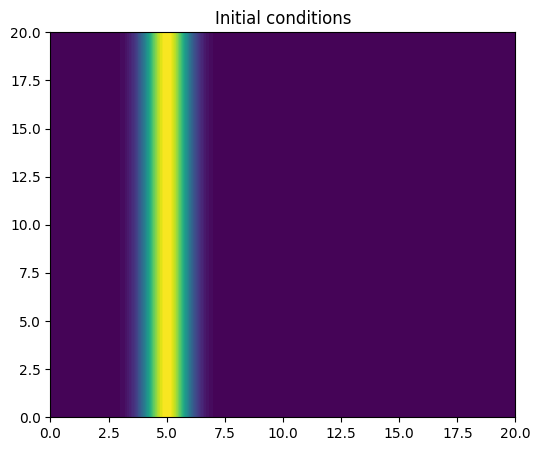

solving 2D wave equation. timestep::   0%|          | 0/1665 [00:00<?, ?it/s]

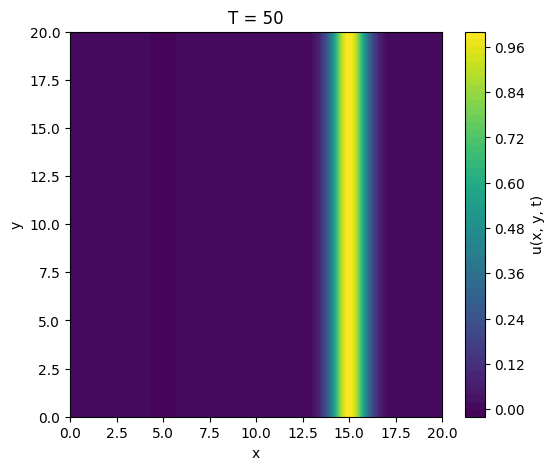

In [37]:
# Define the system
L = 20.0            # spatial length
T = 50              # total simulation length
c = 0.2               # wave speed
r = 0.3             # Courant factor

#discretization
nx = 1000            # number of spatial points
#nt = 1000             # number of time steps

# compute spatial and time steps
dx = L / (nx - 1)  # spatial step
#dt = T / (nt - 1)  # time step
dt = r * dx / c  # time step based on Courant condition
nt = int(T / dt)  # number of time steps
print(f"Performing {nt} time steps")

#need this for plotting and creating the initial conditions
x = np.linspace(0,L,nx)
y = np.linspace(0,L,nx)
X, Y = np.meshgrid(x, y)


def advance_one_step_2d():
    # for i in range(1,nx-1):
    #     for j in range(1,nx-1):
    #         new_step[i,j] = 2 * current_step[i,j] \
    #                     + (r**2) * ( current_step[i+1,j] + current_step[i-1,j] + current_step[i,j+1] + current_step[i,j-1] - 4*current_step[i,j]) \
    #                     - old_step[i,j]
    # the following is MUCH faster because it uses numpy vectorization
    new_step[1:-1, 1:-1] = 2 * (1-2*r**2) * current_step[1:-1, 1:-1] \
                + (r**2) * ( current_step[0:-2, 1:-1] + current_step[2:, 1:-1] + current_step[1:-1, 0:-2] + current_step[1:-1, 2:] ) \
                - old_step[1:-1, 1:-1]
    #boundary conditions:
    new_step[0, :] = new_step[1, :]
    new_step[-1, :] = new_step[-2, :]
    new_step[:, 0] = new_step[:, 1]
    new_step[:, -1] = new_step[:, -2]


def make_initial_conditions_2d(center, amplitude, sigma):
    #2D Gaussian
    #initial_step = amplitude * np.exp(-((X-center[0])**2 + (Y-center[1])**2)/sigma**2)
    # Gaussian wave
    initial_step = amplitude * np.exp(-((X-center[0])**2)/sigma**2)

    return initial_step


#create spatial grids
current_step = make_initial_conditions_2d((5,5), 1, 1)
# For a traveling wave, in the step before the wave was at the current position minus c*dt.
old_step     = make_initial_conditions_2d((5-c*dt,5), 1, 1)
new_step     = np.zeros((nx, nx))


# # Visualization
plt.figure(figsize=(6, 5))
plt.contourf(X, Y, current_step, levels=50, cmap='viridis')
plt.title("Initial conditions")
plt.show()
plt.close()

for iteration_number in trange(nt, desc='solving 2D wave equation. timestep:'):
    print(f"iteration {iteration_number}", end='\r')
    advance_one_step_2d()

    #now update step variables
    old_step = current_step.copy()
    current_step = new_step.copy()


plt.figure(figsize=(6, 5))
plt.contourf(X, Y, current_step, levels=50, cmap='viridis')
plt.colorbar(label='u(x, y, t)')
plt.title(f"T = {T}")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

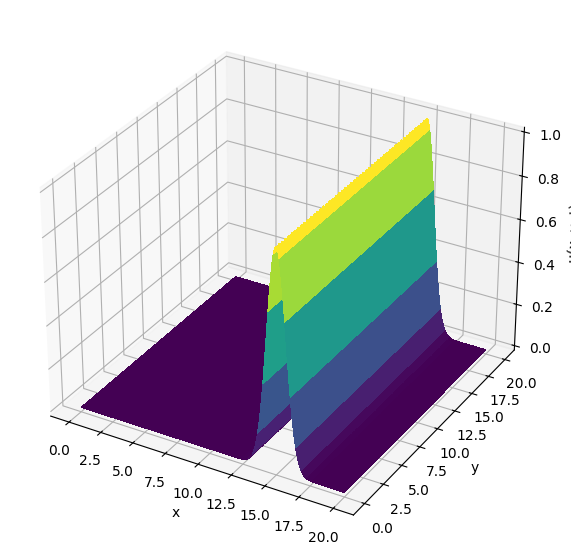

In [38]:
from mpl_toolkits.mplot3d import axes3d

# Plot
fig = plt.figure(figsize = (7,7))

ax = plt.axes(projection='3d')

z = ax.plot_surface(X, Y, current_step, cmap='viridis', linewidth=0, antialiased=False)

# Customised labels for axes
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u(x, y, t)')


plt.show()



## Raindrops
We can use this to simulate raindrops on a pond.

In [39]:
def add_drop(center):
    drop = np.exp(-((X-center[0])**2 + (Y-center[1])**2)/(0.01**2))

    return drop

In [40]:
!pip install cmasher

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.5/506.5 kB 7.0 MB/s eta 0:00:00


pygame 2.6.1 (SDL 2.28.4, Python 3.11.13)
Hello from the pygame community. https://www.pygame.org/contribute.html
Performing 1665 time steps


  0%|          | 0/1665 [00:00<?, ?it/s]

Added a drop at (2.3218699184496505, 6.806404786029532) in iteration 64
Added a drop at (0.3316085738075558, 13.500853173199818) in iteration 84
Added a drop at (2.90298115077144, 11.564419112943895) in iteration 106
Added a drop at (8.375833034126213, 17.037080384944105) in iteration 114
Added a drop at (9.695054901284388, 5.845282563692287) in iteration 122
Added a drop at (0.03968672366820192, 2.7377920503159547) in iteration 152
Added a drop at (11.868029069949522, 15.503708080992254) in iteration 192
Added a drop at (6.175285851045668, 12.0282472850025) in iteration 248
Added a drop at (8.78789821418974, 15.032410806694973) in iteration 283
Added a drop at (19.688099971278064, 19.45271610991173) in iteration 343
Added a drop at (2.6536113200718403, 12.75681058371384) in iteration 376
Added a drop at (14.17546280102968, 10.098182695025733) in iteration 520
Added a drop at (10.021963516156925, 0.6286259731493415) in iteration 536
Added a drop at (3.004970435407066, 19.80733889362257

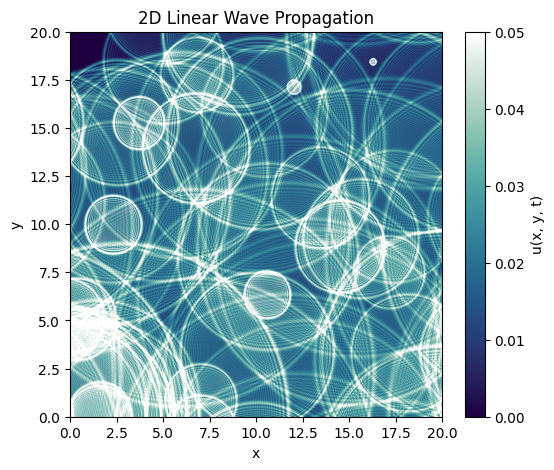

In [41]:
import cmasher as cmr
import pygame as pg
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange

# Define the system
L = 20.0            # spatial length
T = 50              # total simulation length
c = 0.2               # wave speed
r = 0.3             # Courant factor

#discretization
nx = 1000            # number of spatial points
#nt = 1000             # number of time steps

# compute spatial and time steps
dx = L / (nx - 1)  # spatial step
#dt = T / (nt - 1)  # time step
dt = r * dx / c  # time step based on Courant condition
nt = int(T / dt)  # number of time steps
print(f"Performing {nt} time steps")

drop_probability = 0.03


#need this for plotting and creating the initial conditions
x = np.linspace(0,L,nx)
y = np.linspace(0,L,nx)
X, Y = np.meshgrid(x, y)


def advance_one_step_2d():

    new_step[1:-1, 1:-1] = 2 * (1-2*r**2) * current_step[1:-1, 1:-1] \
                + (r**2) * ( current_step[0:-2, 1:-1] + current_step[2:, 1:-1] + current_step[1:-1, 0:-2] + current_step[1:-1, 2:] ) \
                - old_step[1:-1, 1:-1]

    #boundary conditions:
    new_step[0, :] = new_step[1, :]
    new_step[-1, :] = new_step[-2, :]
    new_step[:, 0] = new_step[:, 1]
    new_step[:, -1] = new_step[:, -2]


#Initial conditions, we start with a quiet pond
old_step     = np.zeros((nx, nx))
current_step = np.zeros((nx, nx))
new_step     = np.zeros((nx, nx))

# Visualization
pg.init()
display = pg.display.set_mode((nx, nx))
pixeldata = np.zeros((nx, nx), dtype=np.uint8 )

def step_to_cmap(step, vmin=0, vmax=1, cmap='viridis'):
    normed = np.clip(current_step, vmin, vmax)
    normed = (normed - vmin) / (vmax - vmin)
    cmap = plt.get_cmap(cmap)
    rgb_array = (cmap(normed)[..., :3] * 255).astype(np.uint8)
    return rgb_array


for iteration_number in trange(nt):

    #randomly decide if a drop is added
    if np.random.rand() < drop_probability:
        center = (np.random.rand() * 20, np.random.rand() * 20)
        current_step += add_drop(center)
        print(f"Added a drop at {center[0], center[1]} in iteration {iteration_number}")

    print(f"iteration {iteration_number}/{nt}", end='\r')
    advance_one_step_2d()

    #now update step variables
    old_step = current_step.copy()
    current_step = new_step.copy()

    #visualization
    rgb_array = step_to_cmap(current_step, vmin=0, vmax=0.05, cmap='cmr.ocean')
    surf = pg.surfarray.make_surface(rgb_array[:,::-1])
    display.blit(pg.transform.scale(surf, (nx, nx)), (0, 0))
    pg.display.update()

pg.quit()
# Visualization
plt.figure(figsize=(6, 5))
#plt.contourf(X, Y, current_step, levels=50, cmap='viridis')
plt.imshow(current_step.T, origin='lower', extent=(0, L, 0, L), aspect='auto', cmap='cmr.ocean', vmin=0, vmax=0.05)
plt.colorbar(label='u(x, y, t)')
plt.title("2D Linear Wave Propagation")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Case 3.1: 2D waves with damping

Equation:

$$ \frac{\partial^2 u}{\partial t^2} = c^2 \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right) - 2k\frac{\partial u}{\partial t}$$

Apply finite differences:

$$
\frac{u_{i,j}^{n+1} + u_{i,j}^{n-1} - 2 u_{i,j}^n}{\Delta t^2} = c^2 \frac{u_{i+1, j}^n + u_{i-1, j}^n + u_{i, j+1}^n + u_{i, j-1}^n - 4 u_{i, j}^n}{\Delta x^2} -2 k \frac{u_{i,j}^{n+1} - u_{i,j}^{n-1}}{2\Delta t^2}
$$

Find update rule:

$$u_{i,j}^{n+1} = 2 \frac{1 - 2 r^2}{1+2k\Delta t} u_{i,j}^{n} + \frac{r^2}{1+2k\Delta t} \left( u_{i+1, j}^n + u_{i-1, j}^n + u_{i, j+1}^n + u_{i, j-1}^n \right) - \frac{1-2k\Delta t}{1+2k\Delta t}u_{i,j}^{n-1}$$

## ...and boats!
If we want to simulate a boat in the middle of the pond, we can simply apply a new boundary condition in a rectangle (the best boat shape) somewhere in the pond. We will treat the boat edge in the same way we do for the simulation box boundaries.


pygame 2.6.1 (SDL 2.28.4, Python 3.13.2)
Hello from the pygame community. https://www.pygame.org/contribute.html
Performing 1665 time steps
Added a drop at (9.024769805685146, 10.515419904442723) in iteration 25
Added a drop at (8.388158797860957, 4.628938858296696) in iteration 29
Added a drop at (14.420183770963424, 13.192990127705325) in iteration 95
Added a drop at (2.2821217559826423, 13.939823544669279) in iteration 104
Added a drop at (18.970743542615974, 13.959991798586834) in iteration 220
Added a drop at (12.132768466512527, 0.20991089251474415) in iteration 230
Added a drop at (9.149232531709568, 16.86509773380592) in iteration 298
Added a drop at (15.915141024503917, 16.083333554873086) in iteration 334
Added a drop at (13.365629027401786, 10.24578612162636) in iteration 346
Added a drop at (5.207701512216067, 14.890056131886585) in iteration 348
Added a drop at (1.3243460504403815, 2.561733351542428) in iteration 356
Added a drop at (2.0451855159718324, 12.70970536605934) 

ValueError: not enough values to unpack (expected 6, got 4)

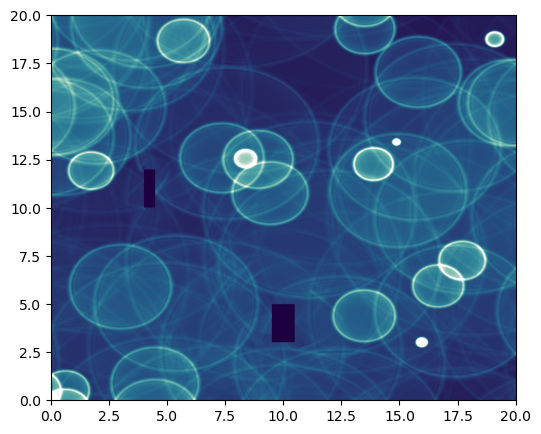

In [ ]:
import cmasher as cmr
import pygame as pg
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from tqdm.notebook import trange

# Define the system
L = 20.0            # spatial length
T = 50              # total simulation length
c = 0.2               # wave speed
r = 0.3             # Courant factor

#discretization
nx = 1000            # number of spatial points
#nt = 1000             # number of time steps

# compute spatial and time steps
dx = L / (nx - 1)  # spatial step
#dt = T / (nt - 1)  # time step
dt = r * dx / c  # time step based on Courant condition
nt = int(T / dt)  # number of time steps
print(f"Performing {nt} time steps")

drop_probability = 0.03
k = 0.03 #  # damping factor

boats = []

#need this for plotting and creating the initial conditions
x = np.linspace(0,L,nx)
y = np.linspace(0,L,nx)
X, Y = np.meshgrid(x, y)

def add_drop(center):
    drop = np.exp(-((X-center[0])**2 + (Y-center[1])**2)/(0.05**2))

    return drop


def advance_one_step_2d():
    new_step[1:-1, 1:-1] = 2 * (1-2*r**2) / (1 + 2*k*dt) * current_step[1:-1, 1:-1] \
                + (r**2) / (1 + 2*k*dt) * ( current_step[0:-2, 1:-1] + current_step[2:, 1:-1] + current_step[1:-1, 0:-2] + current_step[1:-1, 2:] ) \
                - (1 - 2*k*dt) / (1 + 2*k*dt) * old_step[1:-1, 1:-1]

def add_boat(x0, x1, y0, y1):
    p0 = int(x0/dx)
    p1 = int(x1/dx)
    q0 = int(y0/dx)
    q1 = int(y1/dx)
    boats.append((p0, p1, q0, q1))


def draw_boats(rgb_array):
    boat_color = np.array([139,69,19])  # saddle brown
    for p0, p1, q0, q1 in boats:
        rgb_array[p0:p1, q0:q1] = boat_color
    return rgb_array


def apply_boundary_conditions():
    new_step[0, :] = new_step[1, :]
    new_step[-1, :] = new_step[-2, :]
    new_step[:, 0] = new_step[:, 1]
    new_step[:, -1] = new_step[:, -2]

    for p0, p1, q0, q1 in boats:
        new_step[p0:p1, q0:q1] = 0
        new_step[p0, q0:q1] = new_step[p0-1, q0:q1]
        new_step[p1, q0:q1] = new_step[p1+1, q0:q1]
        new_step[p0:p1, q0] = new_step[p0:p1, q0-1]
        new_step[p0:p1, q1] = new_step[p0:p1, q1+1]

#Initial conditions, we start with a quiet pond
old_step     = np.zeros((nx, nx))
current_step = np.zeros((nx, nx))
new_step     = np.zeros((nx, nx))

# Visualization
pg.init()
display = pg.display.set_mode((nx, nx))
pixeldata = np.zeros((nx, nx), dtype=np.uint8 )

def step_to_cmap(step, vmin=0, vmax=1, cmap='viridis'):
    normed = np.clip(current_step, vmin, vmax)
    normed = (normed - vmin) / (vmax - vmin)
    cmap = plt.get_cmap(cmap)
    rgb_array = (cmap(normed)[..., :3] * 255).astype(np.uint8)
    return rgb_array


add_boat(4,4.5,10,12)
add_boat(9.5,10.5,3,5)

for iteration_number in range(nt):

    #randomly decide if a drop is added
    if np.random.rand() < drop_probability:
        center = (np.random.rand() * 20, np.random.rand() * 20)
        current_step += add_drop(center)
        print(f"Added a drop at {center[0], center[1]} in iteration {iteration_number}")

    print(f"iteration {iteration_number}/{nt}", end='\r')
    advance_one_step_2d()
    apply_boundary_conditions()

    #now update step variables
    old_step = current_step.copy()
    current_step = new_step.copy()

    #visualization
    rgb_array = step_to_cmap(current_step, vmin=0, vmax=2, cmap='cmr.ocean')
    draw_boats(rgb_array)
    surf = pg.surfarray.make_surface(rgb_array[:,::-1])
    display.blit(pg.transform.scale(surf, (nx, nx)), (0, 0))
    pg.display.update()



pg.quit()
# Visualization
plt.figure(figsize=(6, 5))
#plt.contourf(X, Y, current_step, levels=50, cmap='viridis')
plt.imshow(current_step.T, origin='lower', extent=(0, L, 0, L), aspect='auto', cmap='cmr.ocean', vmin=0, vmax=1)
for boat in boats:
    p0, p1, q0, q1 = boat
    plt.gca().add_patch(Rectangle((p0*dx, q0*dx), (p1-p0)*dx, (q1-q0)*dx, color='saddlebrown', alpha=0.5))
plt.colorbar(label='u(x, y, t)')
plt.title("2D Linear Wave Propagation")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Moving boat

Performing 666 time steps


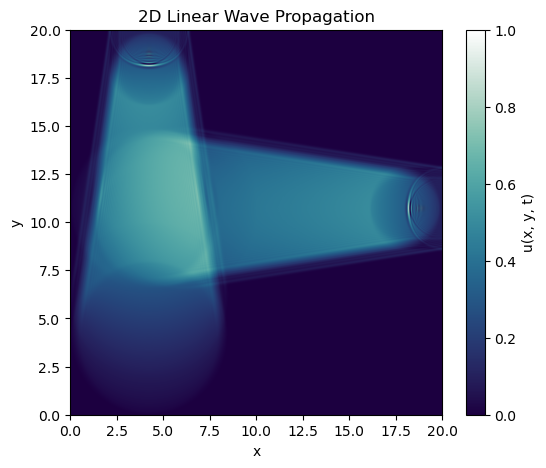

In [ ]:
import cmasher as cmr
import pygame as pg
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from tqdm.notebook import trange

# Define the system
L = 20.0            # spatial length
T = 20              # total simulation length
c = 0.2               # wave speed
r = 0.3             # Courant factor

#discretization
nx = 1000            # number of spatial points
#nt = 1000             # number of time steps

# compute spatial and time steps
dx = L / (nx - 1)  # spatial step
#dt = T / (nt - 1)  # time step
dt = r * dx / c  # time step based on Courant condition
nt = int(T / dt)  # number of time steps
print(f"Performing {nt} time steps")

drop_probability = 0.03
k = 0.03 #  # damping factor

boats = []

#need this for plotting and creating the initial conditions
x = np.linspace(0,L,nx)
y = np.linspace(0,L,nx)
X, Y = np.meshgrid(x, y)


def advance_one_step_2d():
    new_step[1:-1, 1:-1] = 2 * (1-2*r**2) / (1 + 2*k*dt) * current_step[1:-1, 1:-1] \
                + (r**2) / (1 + 2*k*dt) * ( current_step[0:-2, 1:-1] + current_step[2:, 1:-1] + current_step[1:-1, 0:-2] + current_step[1:-1, 2:] ) \
                - (1 - 2*k*dt) / (1 + 2*k*dt) * old_step[1:-1, 1:-1]

def add_boat(x0, x1, y0, y1, v0, v1):
    p0 = int(x0/dx)
    p1 = int(x1/dx)
    q0 = int(y0/dx)
    q1 = int(y1/dx)
    boats.append((p0, p1, q0, q1, v0, v1))


def draw_boats(rgb_array):
    boat_color = np.array([139,69,19])  # saddle brown
    for p0, p1, q0, q1, v0, v1 in boats:
        rgb_array[p0:p1, q0:q1] = boat_color
    return rgb_array


def apply_boundary_conditions():
    new_step[0, :] = new_step[1, :]
    new_step[-1, :] = new_step[-2, :]
    new_step[:, 0] = new_step[:, 1]
    new_step[:, -1] = new_step[:, -2]

    for p0, p1, q0, q1, v0, v1 in boats:
        new_step[p0:p1, q0:q1] = 0
        new_step[p0, q0:q1] = new_step[p0-1, q0:q1]
        new_step[p1, q0:q1] = new_step[p1+1, q0:q1]
        new_step[p0:p1, q0] = new_step[p0:p1, q0-1]
        new_step[p0:p1, q1] = new_step[p0:p1, q1+1]
        if v0 > 0:
            new_step[p1, q0:q1+1] += 1
            new_step[p0, q0:q1+1] += 0.03
        elif v0 < 0:
            new_step[p1, q0:q1+1] += 0.03
            new_step[p0, q0:q1+1] += 1

        if v1 > 0:
            new_step[p0:p1+1, q0] += 0.03
            new_step[p0:p1+1, q1] += 1
        elif v1 < 0:
            new_step[p0:p1+1, q0] += 1
            new_step[p0:p1+1, q1] += 0.03

def move_boats():
    boats_to_remove = []
    for i in range(len(boats)):
        p0, p1, q0, q1, v0, v1 = boats[i]
        #move the boat
        boats[i] = (p0 + int(v0*dt/dx), p1 + int(v0*dt/dx), q0 + int(v1*dt/dx), q1 + int(v1*dt/dx), v0, v1)
        #if the boat goes out of bounds, remove it
        if boats[i][0] < 1 or boats[i][1] >= nx-1 or boats[i][2] < 1 or boats[i][3] >= nx-1:
            boats_to_remove.append(i)

    for i in reversed(boats_to_remove):
        boats.pop(i)

#Initial conditions, we start with a quiet pond
old_step     = np.zeros((nx, nx))
current_step = np.zeros((nx, nx))
new_step     = np.zeros((nx, nx))

# Visualization
pg.init()
display = pg.display.set_mode((nx, nx))
pixeldata = np.zeros((nx, nx), dtype=np.uint8 )

def step_to_cmap(step, vmin=0, vmax=1, cmap='viridis'):
    normed = np.clip(current_step, vmin, vmax)
    normed = (normed - vmin) / (vmax - vmin)
    cmap = plt.get_cmap(cmap)
    rgb_array = (cmap(normed)[..., :3] * 255).astype(np.uint8)
    return rgb_array


add_boat(4, 4.5, 4,    6,    0, 1.5)
add_boat(4,   6, 10.5, 11, 1.5,   0)

for iteration_number in range(nt):

    print(f"iteration {iteration_number}/{nt}", end='\r')
    move_boats()
    advance_one_step_2d()
    apply_boundary_conditions()

    #now update step variables
    old_step = current_step.copy()
    current_step = new_step.copy()

    #visualization
    rgb_array = step_to_cmap(current_step, vmin=0, vmax=1, cmap='cmr.ocean')
    draw_boats(rgb_array)
    surf = pg.surfarray.make_surface(rgb_array[:,::-1])
    display.blit(pg.transform.scale(surf, (nx, nx)), (0, 0))
    pg.display.update()


pg.quit()
# Visualization
plt.figure(figsize=(6, 5))
#plt.contourf(X, Y, current_step, levels=50, cmap='viridis')
plt.imshow(current_step.T, origin='lower', extent=(0, L, 0, L), aspect='auto', cmap='cmr.ocean', vmin=0, vmax=1)
for boat in boats:
    p0, p1, q0, q1, v0, v1 = boat
    plt.gca().add_patch(Rectangle((p0*dx, q0*dx), (p1-p0)*dx, (q1-q0)*dx, color='saddlebrown', alpha=0.5))
plt.colorbar(label='u(x, y, t)')
plt.title("2D Linear Wave Propagation")
plt.xlabel("x")
plt.ylabel("y")
plt.show()